# Pytorch Tensors 
Welcome! In this notebook you will learn what a **tensor** is, how to create and inspect tensors, and finally how to build a very small neural network (**MLP**) using torch. Each topic has a short text you can read first, then a code cell you can run.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyperskill-content/hyperskill-ml-notebooks/blob/main/pytorch_tensors.ipynb)

## 🚀 Prerequisites

Make sure you’re comfortable with the topics below before starting this notebook:

| # | Topic (clickable links)|
|---|-------|
| 1 | **[Introduction to PyTorch](https://hyperskill.org/learn/step/34436)**  |
| 2 | **[Basics of neural network architecture](https://hyperskill.org/learn/step/26997)** |
| 3 | **[Activation functions](https://hyperskill.org/learn/step/35741)** | 
| 4 | **[Multilayer perceptron](https://hyperskill.org/learn/step/47283)** | 

*If you’re new to any item above, review it quickly, then dive back in here.*

# 📑 Table of Contents

1. [What Is a Tensor?](#sec-tensor)  
2. [Inspecting a Tensor](#sec-inspect)  
3. [Creating Tensors](#sec-create)  
4. [Indexing & Slicing](#sec-index)  
5. [Reshaping & Transposing](#sec-reshape)  
6. [In-Place vs Out-of-Place Ops](#sec-inplace)  
7. [Broadcasting](#sec-broadcast)  
8. [Mini Exercise — RGB to Grayscale](#sec-grayscale)  
9. [Tiny MLP](#sec-mlp)


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.2


### 1. What Is a Tensor?
<a id="sec-tensor"></a>
A **tensor** is simply a multidimensional array of numbers.  
* A single number is a **0-D tensor** (scalar).  
* A list like `[1, 2, 3]` is a **1-D tensor** (vector).  
* A table of numbers is a **2-D tensor** (matrix).  
PyTorch stores tensors efficiently and lets us move them to GPU for speed.


In [2]:
scalar = torch.tensor(7)                # 0-D
vector = torch.tensor([1, 2, 3])        # 1-D
matrix = torch.tensor([[1, 2], [3, 4]]) # 2-D
print("scalar:", scalar)
print("vector:", vector)
print("matrix:\n", matrix)


scalar: tensor(7)
vector: tensor([1, 2, 3])
matrix:
 tensor([[1, 2],
        [3, 4]])


### 2. Inspecting a Tensor — First Things to Check
<a id="sec-inspect"></a>
Before any operation, ask three quick questions:

| Property | Why you need it | How to get it |
|----------|-----------------|---------------|
| **shape** | does it fit the layer? | `x.shape` |
| **dtype** | float, int, bool? | `x.dtype` |
| **device** | CPU or GPU? | `x.device` |

Bonus helpers:  
* `x.ndim` → number of dimensions  
* `x.numel()` → total elements  
* `x.stride()` → memory step size per dim (helps with speed issues)


In [3]:
x = torch.rand(2, 3, 4)
print("shape :", x.shape)
print("dtype :", x.dtype)
print("device:", x.device)
print("ndim  :", x.ndim)
print("numel :", x.numel())
print("stride:", x.stride())


shape : torch.Size([2, 3, 4])
dtype : torch.float32
device: cpu
ndim  : 3
numel : 24
stride: (12, 4, 1)


### 3. Creating Tensors — Your Toolkit
<a id="sec-create"></a>

Use these factory functions every day:

| Function | Typical use |
|----------|-------------|
| `torch.zeros` | initialise weights / masks |
| `torch.ones`  | add bias of ones |
| `torch.empty` | reserve memory fast (values uninitialised) |
| `torch.full`  | constant tensors (e.g. padding value) |
| `torch.arange`, `torch.linspace` | index vectors, positional encodings |

*Real-world tip:* Random initialisation matters — try different seeds when models misbehave.


In [4]:
z = torch.zeros(2, 3)
o = torch.ones(2, 3)
r = torch.arange(0, 6).reshape(2, 3)
l = torch.linspace(0, 1, steps=5)
c = torch.full((2, 3), 42)
print("zeros:\n", z)
print("range:\n", r)
print("ones:\n", o)
print("linspace:\n", l)
print("full:\n", c)


zeros:
 tensor([[0., 0., 0.],
        [0., 0., 0.]])
range:
 tensor([[0, 1, 2],
        [3, 4, 5]])
ones:
 tensor([[1., 1., 1.],
        [1., 1., 1.]])
linspace:
 tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
full:
 tensor([[42, 42, 42],
        [42, 42, 42]])


### 4. Indexing & Slicing — Grabbing What You Need
<a id="sec-index"></a>

Like NumPy, but with gradients.

* Row / column selection  
* Boolean masks for filtering  
* Concatenation (`torch.cat`) and stacking (`torch.stack`) to merge data  
  *Use case:* building mini-batches from separate tensors.


In [5]:
a = torch.arange(12).reshape(3, 4)
print("a:\n", a)
print("row 1 :", a[1])          # second row
print("col 0 :", a[:, 0])       # first column
mask = a % 2 == 0
print("evens :", a[mask])       # boolean filter

b = torch.ones_like(a)
cat = torch.cat([a, b], dim=0)  # join rows
stk = torch.stack([a, b], dim=1)# add new dim
print("cat shape:", cat.shape)
print("stack shape:", stk.shape)


a:
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
row 1 : tensor([4, 5, 6, 7])
col 0 : tensor([0, 4, 8])
evens : tensor([ 0,  2,  4,  6,  8, 10])
cat shape: torch.Size([6, 4])
stack shape: torch.Size([3, 2, 4])


### 5. Reshaping & Transposing — Same Data, New View
<a id="sec-reshape"></a>

* `view`, `reshape` → change shape without moving data (fast)  
* `transpose`, `permute` → reorder dimensions  
* `.contiguous()` → make memory continuous if needed

**Use case:** Flatten images before a linear layer or swap channels for OpenCV (torch uses RGB and opencv BGR channel orders)


In [6]:
v = torch.arange(8)
m = v.view(2, 4)        # 2×4
t = m.T                 # 4×2
print("matrix:\n", m)
print("transposed:\n", t)
print("is contiguous:", t.is_contiguous())
t_c = t.contiguous().view(-1)
print("flattened:", t_c)


matrix:
 tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])
transposed:
 tensor([[0, 4],
        [1, 5],
        [2, 6],
        [3, 7]])
is contiguous: False
flattened: tensor([0, 4, 1, 5, 2, 6, 3, 7])


### 6  In-Place (`*_`) vs. Out-of-Place Operations
<a id="sec-inplace"></a>

* **Out-of-place** – creates a **new tensor**, original stays the same.  
* **In-place** – ends with an underscore `_` and **changes data inside the same tensor**.  

In-place saves memory but can break Autograd if you try it on a **leaf tensor** (a tensor you created with `requires_grad=True`).  
PyTorch will stop you with the error:
```
RuntimeError: a leaf Variable that requires grad is being used in an in-place operation
```
Below are quick demos:

1. Safe out-of-place  
2. In-place error on a leaf tensor  
3. Two safe work-arounds  
4. In-place on a non-leaf tensor (works)

In [7]:
# 1️⃣  Safe out-of-place
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = x + 1          # new tensor
print("x:", x)     # [1., 2., 3.]
print("y:", y)     # [2., 3., 4.]

x: tensor([1., 2., 3.], requires_grad=True)
y: tensor([2., 3., 4.], grad_fn=<AddBackward0>)


In [8]:
# 2️⃣  In-place on a leaf tensor → error
z = torch.tensor([1., 2., 3.], requires_grad=True)
z.add_(1)          # raises RuntimeError

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
# 3️⃣  Safe in-place methods

# 3a. Use torch.no_grad()
w = torch.tensor([1., 2., 3.], requires_grad=True)
with torch.no_grad():
    w.add_(1)
print("w:", w)     # [2., 3., 4.]

# 3b. Detach first
u = torch.tensor([1., 2., 3.], requires_grad=True)
u_det = u.detach()
u_det.add_(1)
print("u_det:", u_det)   # [2., 3., 4.]

w: tensor([2., 3., 4.], requires_grad=True)
u_det: tensor([2., 3., 4.])


In [9]:
# 4️⃣  In-place on a non-leaf tensor (allowed)
root  = torch.tensor([1., 2., 3.], requires_grad=True)
child = root * 2            # not a leaf
child.add_(1)               # in-place ok
out = child.sum()
out.backward()
print("root.grad:", root.grad)   # tensor([2., 2., 2.])

root.grad: tensor([2., 2., 2.])


**Key points**

* You can always use out-of-place ops—they’re simple and safe, unless you have a memory limitations.
* If you really need in-place, wrap it in `torch.no_grad()` or use `.detach()`.  
* PyTorch optimisers already handle in-place parameter updates for you.

### 7. Broadcasting — Math with Different Shapes
<a id="sec-broadcast"></a>
Broadcasting lets PyTorch stretch a smaller tensor to match a larger one.

**Use case:** Add channel-wise mean / std when normalising images.


In [10]:
mat = torch.rand(2, 3)
vec = torch.tensor([1.0, 0.5, 0.0])   # shape (3,)
res = mat + vec                       # vec → (2,3)
print(res)


tensor([[1.9916, 0.7508, 0.4694],
        [1.3362, 1.4189, 0.0522]])


### 8. Mini Exercise — From RGB to Grayscale
<a id="sec-grayscale"></a>

Goal:  
*Take a batch of RGB images, convert each one to a single-channel grayscale image, then check the new shape.*

Why it matters:  
Many computer-vision tasks (e.g., edge detection, classic ML models) need **1-channel** input instead of color.  
Knowing how to reduce channels is a handy tensor skill.


In [11]:
# Batch of 16 RGB images with pixel values in [0, 1]
imgs = torch.rand(16, 3, 128, 128)        # shape (B, C, H, W)

# Average the 3 colour channels → grayscale
gray = imgs.mean(dim=1, keepdim=True)     # shape becomes (B, 1, H, W)

print("original shape:", imgs.shape)
print("grayscale shape:", gray.shape)

# Optional: verify range still [0, 1]
print("min/max:", gray.min().item(), gray.max().item())


original shape: torch.Size([16, 3, 128, 128])
grayscale shape: torch.Size([16, 1, 128, 128])
min/max: 0.010739028453826904 0.9929993152618408


## 9️⃣ Tiny MLP — How It Works
 
<a id="sec-mlp"></a>

A **Multilayer Perceptron (MLP)** is the hello-world of neural networks.  
Ours has three main parts:

| Part | What it does | Why it matters |
|------|--------------|----------------|
| **Flatten layer** | Turns a 3-D image `(C × H × W)` into a 1-D vector | Linear layers need 1-D input |
| **Linear + ReLU (hidden layer)** | `x → Wx + b`, then keep only positive values | Learns mixed features (edges, colours, …) |
| **Linear (output layer)** | New weights turn hidden features into **logits** (raw scores) | One logit per class (10 here) |
| **Softmax (optional)** | Converts logits to probabilities that sum to 1 | Easier to read & plot |

> **Why just two layers?**  
> Small models train fast and make debugging easy. Once the flow is clear, you can add more layers or switch to ConvNets.

In the demo below you will:

1. Watch shapes change through the network  
2. Turn logits into probabilities  
3. Visualise the predicted class distribution for one sample


input   : torch.Size([4, 3, 224, 224])
flatten : torch.Size([4, 150528])
hidden  : torch.Size([4, 128])
logits  : torch.Size([4, 10])


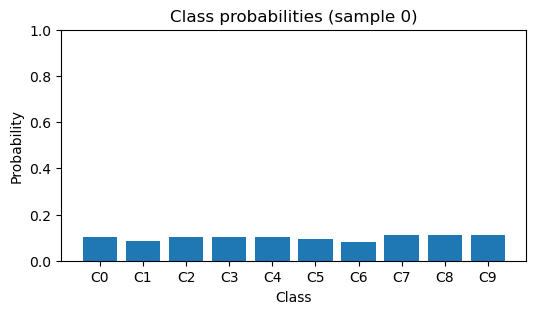

In [5]:
# ----- Tiny MLP definition -----
class TinyMLP(nn.Module):
    def __init__(self, in_features=3*224*224, hidden=128, out=10):
        super().__init__()
        self.flat = nn.Flatten()              # 1️⃣ flatten
        self.hidden = nn.Linear(in_features, hidden)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden, out)

    def forward(self, x):
        print("input   :", x.shape)            # (B, 3, 224, 224)
        x = self.flat(x)
        print("flatten :", x.shape)            # (B, 150 528)
        x = self.act(self.hidden(x))
        print("hidden  :", x.shape)            # (B, 128)
        logits = self.out(x)
        print("logits  :", logits.shape)       # (B, 10)
        return logits

# ----- Fake batch -----
batch = torch.rand(4, 3, 224, 224)            # 4 RGB images

model = TinyMLP()
logits = model(batch)                         # forward pass
probs  = logits.softmax(dim=1)                # nice probabilities

# ----- Visualise probs for the first sample -----
classes = [f"C{i}" for i in range(10)]
plt.figure(figsize=(6,3))
plt.bar(classes, probs[0].detach().numpy())
plt.title("Class probabilities (sample 0)")
plt.ylabel("Probability")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.show()


### 9.1  Autograd in Action — One Training Step

`Autograd` is PyTorch’s automatic-differentiation engine.  
When you call `.backward()`, PyTorch walks back through the graph and fills `.grad` for each parameter.

Below we will:

1. Create **fake labels**.  
2. Compute **cross-entropy loss** on the logits from the Tiny MLP.  
3. Call `loss.backward()` and inspect one gradient tensor.


In [6]:
import torch.nn.functional as F

# ----- fake labels (0-9) -----
targets = torch.randint(0, 10, (logits.size(0),))       # shape (B,)

# ----- loss & backward -----
loss = F.cross_entropy(logits, targets)
print("loss:", loss.item())

loss.backward()    # gradients now stored in model parameters

# show gradient of first weight matrix
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name}.grad shape:", p.grad.shape)
        break


loss: 2.3891186714172363
hidden.weight.grad shape: torch.Size([128, 150528])


### 9.2  Moving Data & Model to GPU

If you have an NVIDIA GPU, you can run the same network **much faster**.

Steps:

1. Pick a device: `"cuda"` if available, else `"cpu"`.  
2. `.to(device)` on **both** data **and** model.  
3. Run the forward pass.  (Optionally, time it.)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# move model and a new dummy batch
model_gpu = TinyMLP().to(device)
batch_gpu  = torch.rand(8, 3, 224, 224, device=device)

# quick timing
with torch.no_grad():
    logits_gpu = model_gpu(batch_gpu)        # forward on GPU / CPU
print("output shape:", logits_gpu.shape)


Using device: cpu
input   : torch.Size([8, 3, 224, 224])
flatten : torch.Size([8, 150528])
hidden  : torch.Size([8, 128])
logits  : torch.Size([8, 10])
output shape: torch.Size([8, 10])


### 9.3  Putting It All Together

* You now know how to **create a model**, **move it to GPU**,  
  **run a forward pass**, **compute loss**, and **back-propagate gradients**.



#### Exercise 1 – Build a 2 × 3 Tensor of Zeros  

Create a tensor named **`t`** with shape `(2, 3)`, all zeros, `dtype=torch.float32`, living on the CPU.


In [ ]:
import torch
# 🚧 Your code below
# t = ...

# 🔎 Tests
assert isinstance(t, torch.Tensor), "Not a tensor"
assert t.shape == (2, 3), "Shape should be (2, 3)"
assert t.dtype == torch.float32, "dtype must be float32"
assert t.device.type == "cpu", "Keep it on CPU for this test"
assert torch.all(t == 0), "Tensor must contain only zeros"
print("✅ Exercise 1 passed!")


#### Exercise 2 – Reshape a Vector to 3 × 4  

Given the 1-D tensor `v` below, create `m` with shape `(3, 4)` **using `view`**.


In [ ]:
v = torch.arange(12)           # [0 … 11]
# 🚧 Your code below
# m = ...

# 🔎 Tests
assert m.shape == (3, 4), "Shape should be (3, 4)"
assert m.is_contiguous(), "Use view, not transpose"
assert torch.equal(m.flatten(), v), "Values must match original order"
print("✅ Exercise 2 passed!")


#### Exercise 3 – Stack Along a New Dimension  

Stack `a` and `b` **along a new leading dimension** so the result has shape `(2, 3, 4)`.  
(Do **not** use a Python list; use `torch.stack`.)


In [ ]:
a = torch.ones(3, 4)
b = torch.zeros(3, 4)
# 🚧 Your code below
# out = ...

# 🔎 Tests
assert out.shape == (2, 3, 4), "Result should be (2, 3, 4)"
assert (out[0] == 1).all() and (out[1] == 0).all(), "Order should be [a, b]"
print("✅ Exercise 3 passed!")


#### Exercise 4 – Convert to Grayscale  

Given a batch `imgs` of shape `(N, 3, H, W)` with values in `[0, 1]`,  
create **`gray`** with shape `(N, 1, H, W)` by averaging the colour channels.


In [ ]:
imgs = torch.rand(5, 3, 64, 64)   # fake batch
# 🚧 Your code below
# gray = ...

# 🔎 Tests
assert gray.shape == (5, 1, 64, 64), "Wrong shape"
assert (gray >= 0).all() and (gray <= 1).all(), "Keep values in [0, 1]"
# spot-check mean
assert torch.allclose(gray[0,0,0,0], imgs[0,:,0,0].mean()), "Averaging mismatch"
print("✅ Exercise 4 passed!")


#### Exercise 5 – Device Transfer  

Move tensor `x` and the TinyMLP `model` to **`cuda`** *if* a GPU is available,  
otherwise leave them on CPU.  Store the result in `x_dev` and `model_dev`.


In [ ]:
x = torch.rand(2, 3, 224, 224)
model = TinyMLP()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 🚧 Your code below
# x_dev = ...
# model_dev = ...

# 🔎 Tests
assert x_dev.device == device, "x_dev on wrong device"
assert next(model_dev.parameters()).device == device, "model_dev on wrong device"
print("✅ Exercise 5 passed!")


## Conclusion

To work confidently with data in PyTorch, start by **creating tensors** with helper functions such as `torch.zeros`, `torch.ones`, or `torch.rand`, then **inspect** them with `.shape`, `.dtype`, and `.device` to catch shape or type errors early.  
When you need a new view of the same data, use `view` / `reshape`; if you must reorder dimensions, rely on `transpose` or `permute`, and call `.contiguous()` before reshaping if the stride is disrupted.

Slice and index tensors just as you would in NumPy, or merge them with `torch.cat` and `torch.stack` to build mini-batches.  
Remember that **out-of-place operations** create new tensors and are always safe, while **in-place operations** (ending in `_`) save memory but cannot be applied to leaf tensors that require gradients without wrapping them in `torch.no_grad()` or detaching first.

Use **broadcasting** to let PyTorch align smaller tensors automatically—ideal for channel-wise operations like converting an RGB batch to a single-channel grayscale batch by averaging along `dim=1`.

After preprocessing, **flatten images** before a `Linear` layer, pass them through a hidden layer with `ReLU`, and produce logits with an output layer to form a **tiny MLP**.  
Compute loss with `torch.nn.functional.cross_entropy`, call `loss.backward()` to fill parameter gradients, and move both data and model to `"cuda"` when a GPU is available to accelerate training.

These steps—tensor creation, inspection, reshaping, safe memory operations, broadcasting, simple preprocessing, Autograd, and GPU transfer—form the everyday toolkit for building and debugging neural-network pipelines in PyTorch.
